In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

from src.utils.preprocessors import *
%load_ext autoreload
%autoreload 2

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.simplefilter('ignore')
sns.set_theme(context='notebook', style=plt.style.use('dark_background')) # type: ignore

In [2]:
# 1. Cargar el archivo YAML
yaml_path = '../../config/features_names.yaml'  # Cambia esto por la ruta de tu archivo
with open(yaml_path, 'r', encoding='utf-8') as file:
    column_mapping = yaml.safe_load(file)['features']  # Carga solo la sección de 'features'

# 2. Lectura de los datos provisionales
data = pl.scan_parquet('../../data/interim/data_interim.parquet').collect()

# 3. Renombrar las columnas según el YAML
data = data.rename(column_mapping)
data.sample(5, seed=42)

country,state,city,target,price,local_pickup,free_shipping,shipping_mode,seller_id,site_id,listing_type,attribute_group_id,attribute_name,attribute_group,attribute_id,buying_mode,category_id,last_updated,product_id,accepts_mercadopago,currency,title,automatic_relist,date_created,stop_time,status,initial_quantity,start_time,sold_quantity,available_quantity
str,str,str,str,f64,bool,bool,str,i64,str,str,str,str,str,str,str,str,datetime[ms],str,bool,str,str,bool,datetime[ms],datetime[ms],str,i64,datetime[ms],i64,i64
"""argentina""","""buenos aires""","""campana""","""used""",93000.0,false,false,"""not_specified""",1403611911,"""mla""","""free""","""find""","""año""","""ficha técnica""","""mla1744-year""","""classified""","""mla29634""",2015-10-07 13:41:46,"""mla9380749349""",false,"""ars""","""chevrolet meriva turbo diesel …",false,2015-10-07 13:37:28,2015-11-06 13:37:27,"""active""",1,2015-10-07 13:37:27,0,1
"""argentina""","""buenos aires""","""pilar""","""new""",111900.0,false,false,"""not_specified""",6054223514,"""mla""","""silver""","""adicionales""","""dirección""","""adicionales""","""mla1744-direc""","""classified""","""mla51456""",2015-09-29 15:12:19,"""mla4430096054""",false,"""ars""","""nuevo volkswagen up! 0km finan…",false,2015-09-29 15:12:15,2015-10-29 18:04:55,"""active""",1,2015-09-29 15:12:15,0,1
"""argentina""","""santa fe""","""rosario""","""new""",220.0,true,false,"""me2""",8105393196,"""mla""","""bronze""","""dflt""","""género""","""otros""","""gender""","""buy_it_now""","""mla119287""",2015-10-06 12:30:51,"""mla6712671939""",true,"""ars""","""remeras punk rock, ramones, th…",false,2015-10-06 12:30:46,2015-12-05 12:30:46,"""active""",597,2015-10-06 12:30:46,4,597
"""argentina""","""buenos aires""","""almirante brown""","""used""",190000.0,false,false,"""not_specified""",8177164127,"""mla""","""gold""","""find""","""marca""","""ficha técnica""","""mla1744-marc""","""classified""","""mla24337""",2015-10-08 05:09:21,"""mla5527412723""",false,"""ars""","""mercedes benz sportcoupe model…",false,2015-08-03 23:44:29,2015-11-09 05:08:38,"""active""",1,2015-08-03 23:44:28,0,1
"""argentina""","""capital federal""","""saavedra""","""used""",25000.0,false,false,"""not_specified""",5251816040,"""mla""","""silver""","""confort""","""gps""","""confort""","""mla1744-gps""","""classified""","""mla29524""",2015-10-14 12:47:04,"""mla5262104672""",false,"""ars""","""chevrolet corsa 5 ptas diesel …",false,2015-10-14 12:46:59,2015-10-18 04:57:06,"""active""",1,2015-10-14 12:46:58,0,1


In [3]:
# Producto que sea nuevo y usado como mismo evento
result = (
    data.group_by('product_id')
    .agg(pl.n_unique('target').alias('unique_conditions'))
    .filter(pl.col('unique_conditions') > 1)  # Filtra los productos con más de una condición
)
result

product_id,unique_conditions
str,u32


In [4]:
# Producto que sea nuevo y usado como mismo evento
result = (
    data.group_by('product_id')
    .agg(pl.n_unique('last_updated').alias('n_unique'))
    .filter(pl.col('n_unique') > 1)  # Filtra los productos con más de una condición
)
result

product_id,n_unique
str,u32


In [5]:
# Producto que sea nuevo y usado como mismo evento
# Conclusión: todos los productos son nuevos o usados con el mismo product_id
data.filter((pl.col('target') == 'new') & (pl.col('target') == 'used')).select('product_id')

product_id
str


In [6]:
# El precio es constante en todas las transacciones
sample = data.sample(1, seed=42).get_column('product_id')[0]
data.filter(pl.col('product_id') == sample).select('product_id', 'price', 'sold_quantity')

product_id,price,sold_quantity
str,f64,i64
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0
…,…,…
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0
"""mla3538569648""",88500.0,0


In [7]:
# El 'product_id', 'price', 'sold_quantity', 'initial_quantity', 'available_quantity', 'date_created', 'last_updated' son constante en todas las transacciones
sample = data.sample(1, seed=85).get_column('product_id')[0]
data.filter(pl.col('product_id') == sample).select('product_id', 'price', 'sold_quantity', 'initial_quantity', 'available_quantity', 'date_created', 'last_updated')

product_id,price,sold_quantity,initial_quantity,available_quantity,date_created,last_updated
str,f64,i64,i64,i64,datetime[ms],datetime[ms]
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
…,…,…,…,…,…,…
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35
"""mla5672241252""",50.0,0,5,5,2015-08-18 11:26:50,2015-09-18 13:21:35


In [8]:
data.schema

Schema([('country', String),
        ('state', String),
        ('city', String),
        ('target', String),
        ('price', Float64),
        ('local_pickup', Boolean),
        ('free_shipping', Boolean),
        ('shipping_mode', String),
        ('seller_id', Int64),
        ('site_id', String),
        ('listing_type', String),
        ('attribute_group_id', String),
        ('attribute_name', String),
        ('attribute_group', String),
        ('attribute_id', String),
        ('buying_mode', String),
        ('category_id', String),
        ('last_updated', Datetime(time_unit='ms', time_zone=None)),
        ('product_id', String),
        ('accepts_mercadopago', Boolean),
        ('currency', String),
        ('title', String),
        ('automatic_relist', Boolean),
        ('date_created', Datetime(time_unit='ms', time_zone=None)),
        ('stop_time', Datetime(time_unit='ms', time_zone=None)),
        ('status', String),
        ('initial_quantity', Int64),
        ('star

In [9]:
# Función de agregación
def aggregate_data(data: pl.LazyFrame, group_by_col: str) -> pl.LazyFrame:
    """
    Realiza la agregación de datos sobre la columna de agrupación especificada.

    Parámetros:
    -----------
    data : pl.LazyFrame
        DataFrame en formato LazyFrame de Polars con los datos originales.
    group_by_col : str
        Nombre de la columna sobre la cual se hará la agrupación (product_id, seller_id, site_id).

    Retorna:
    --------
    pl.LazyFrame
        DataFrame con los datos agregados.
    """
    df_agg = (
        data.group_by(group_by_col)
        .agg([
            pl.col('target').mode().first().alias('condition'),
            pl.col('state').mode().explode().first().alias('state'),
            pl.col('city').mode().explode().first().alias('city'),
            pl.col('local_pickup').mode().explode().first().alias('local_pickup'),
            pl.col('free_shipping').mode().explode().first().alias('free_shipping'),
            pl.col('shipping_mode').mode().explode().first().alias('shipping_mode'),
            pl.col('listing_type').mode().explode().first().alias('listing_type'),
            pl.col('buying_mode').mode().explode().first().alias('buying_mode'),
            
            pl.col('attribute_group_id').mode().explode().first().alias('attribute_group_id'),
            pl.col('attribute_group').mode().explode().first().alias('attribute_group'),
            pl.col('attribute_id').mode().explode().first().alias('attribute_id'),
            
            pl.col('status').mode().explode().first().alias('status'),
            pl.col('accepts_mercadopago').mode().explode().first().alias('accepts_mercadopago'),
            pl.col('currency').mode().explode().first().alias('currency'),
            pl.col('automatic_relist').mode().explode().first().alias('automatic_relist'),
            pl.col('title').mode().explode().first().alias('title'),
            
            pl.first('price').alias('unit_price'),  # Tomamos cualquier valor porque es constante
            pl.sum('sold_quantity').alias('total_quantity'),
            pl.sum('initial_quantity').alias('stock_quantity'),
            pl.sum('available_quantity').alias('available_quantity'),
            pl.first('last_updated').alias('last_updated'),
            pl.first('date_created').alias('date_created'),
            
            pl.first('start_time').alias('start_time'),
            pl.first('stop_time').alias('stop_time'),
        ])
        .with_columns(
            (pl.col('unit_price') * pl.col('total_quantity')).alias('total_amount'),
            ((pl.col('last_updated') - pl.col('date_created')).dt.total_seconds() / 3600).alias('date_difference_hr'),
            ((pl.col('stop_time') - pl.col('start_time')).dt.total_seconds() / 3600).alias('time_difference_hr')
        )#.drop(
            # ['unit_price', 'total_quantity', 'date_created', 'last_updated', 'start_time', 'stop_time']
        #)
    ).sort('total_amount', descending=True)
    
    return df_agg


# Aplicar la función a diferentes niveles de agregación
df_product = aggregate_data(data.lazy(), 'product_id').collect()
df_seller = aggregate_data(data.lazy(), 'seller_id').collect()
df_site = aggregate_data(data.lazy(), 'site_id').collect()

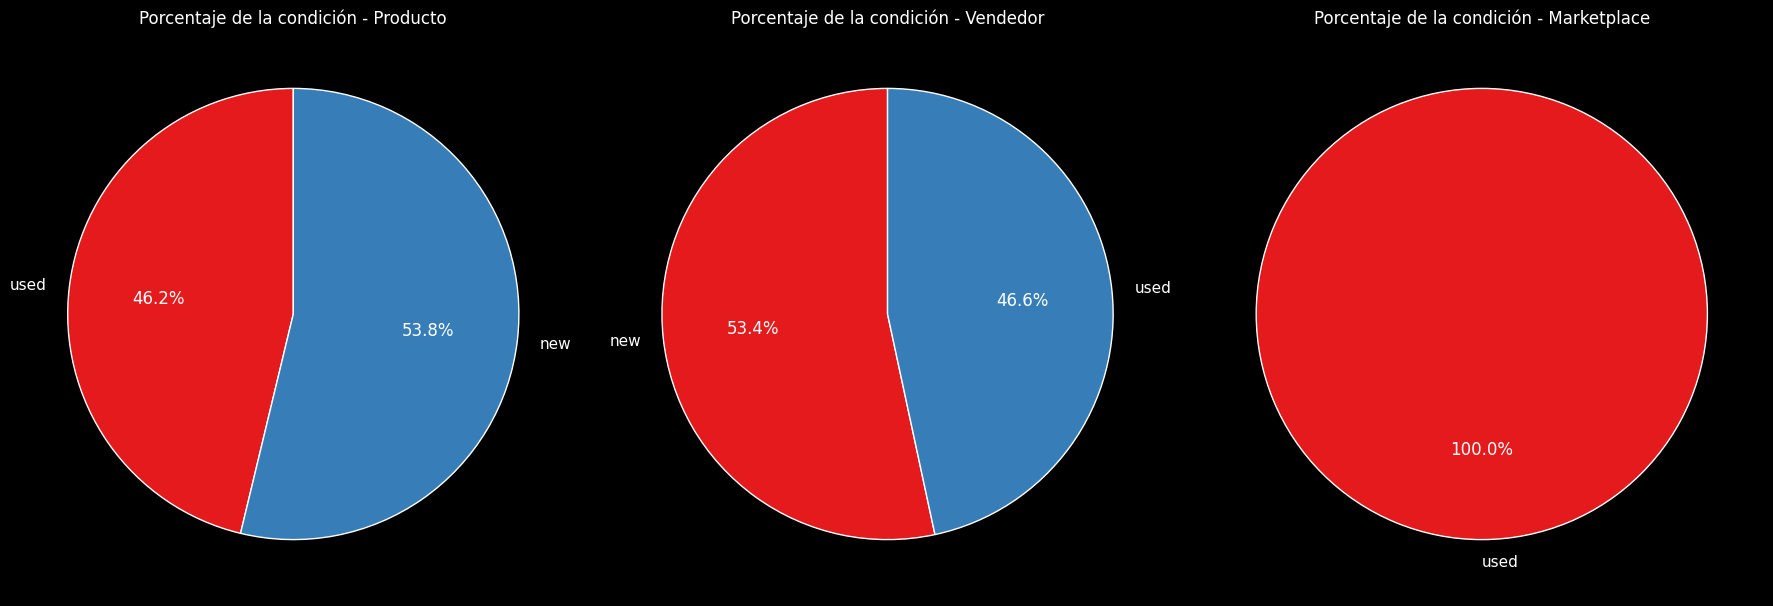

In [10]:
# Lista de DataFrames y sus títulos
dfs = [
    (df_product, 'Producto'),
    (df_seller, 'Vendedor'),
    (df_site, 'Marketplace')
]
VARIABLE = 'condition'

# Configurar la figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterar sobre los DataFrames
for ax, (df, title) in zip(axes, dfs):
    # Calcular las frecuencias de los valores en 'condition'
    fraction_counts = df.select(pl.col(VARIABLE).value_counts()).unnest(VARIABLE)
    
    # Extraer etiquetas y valores
    fraction_labels = fraction_counts[VARIABLE].to_list()
    fraction_values = fraction_counts['count'].to_list()
    
    # Crear gráfico de pastel
    ax.pie(
        fraction_values,
        labels=fraction_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Set1.colors,  # Paleta de colores similar a Set1 de seaborn
        wedgeprops={'edgecolor': 'white'}
    )
    ax.set_title(f'Porcentaje de la condición - {title}', fontsize=12)

# Ajustar el diseño
plt.tight_layout()
plt.show()

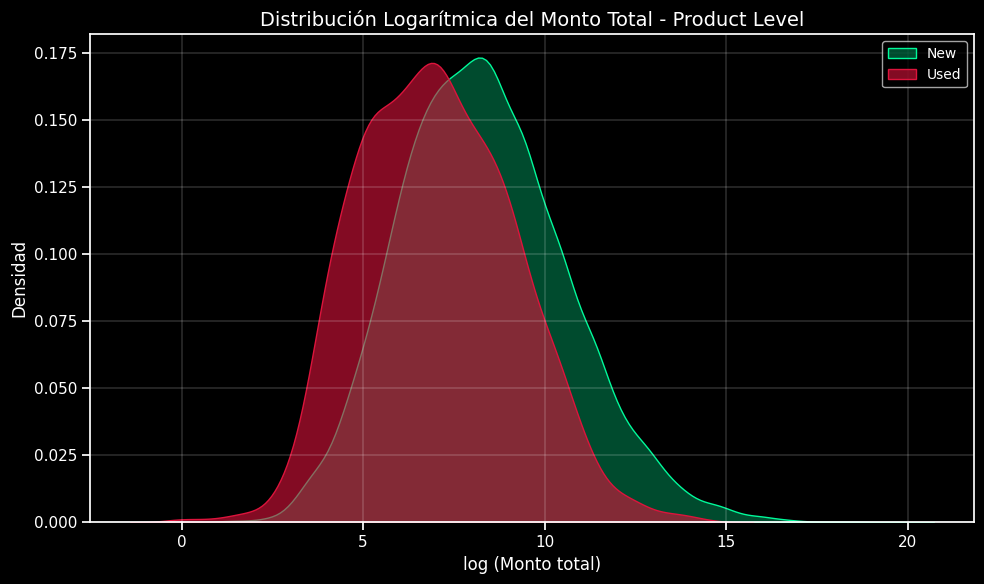

In [11]:
# Convert Polars DataFrame to Pandas after aggregation
df_plot = (
    df_product.group_by('product_id')
    .agg(
        pl.col('total_amount').first().alias('total_amount'),
        pl.col('condition').mode().first().alias('condition'),
    )
    .sort('total_amount', descending=True)
).to_pandas()

# Apply log transformation to avoid log(0)
df_plot['log_total_mount'] = np.log(df_plot['total_amount'])  # log(x)

# Create figure
plt.figure(figsize=(10, 6))

# KDE for 'new' condition
sns.kdeplot(
    data=df_plot[df_plot['condition'] == 'new'],
    x='log_total_mount',
    label='New',
    fill=True,
    alpha=0.3,
    color='mediumspringgreen',
)

# KDE for 'used' condition
sns.kdeplot(
    data=df_plot[df_plot['condition'] == 'used'],
    x='log_total_mount',
    label='Used',
    fill=True,
    alpha=0.6,
    color='crimson',
)

# Customize plot
plt.title('Distribución Logarítmica del Monto Total - Product Level', fontsize=14)
plt.xlabel('log (Monto total)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='white', linewidth=0.2)

# Adjust layout and show
plt.tight_layout()
plt.show()

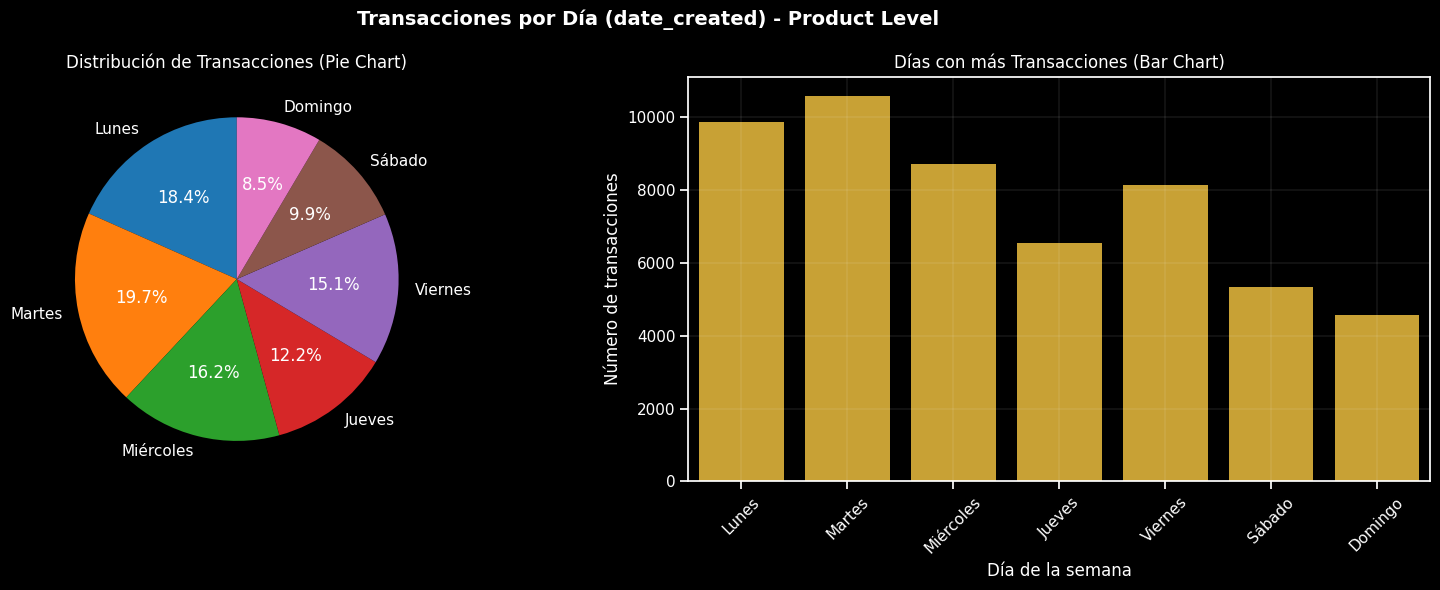

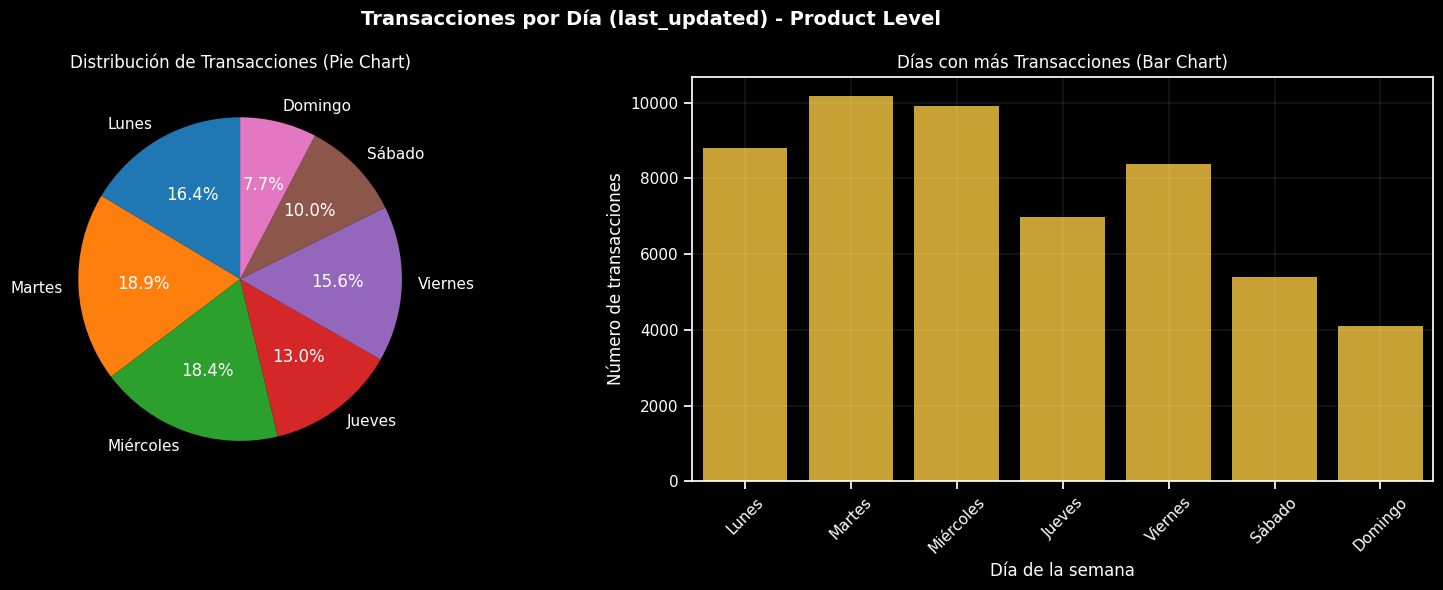

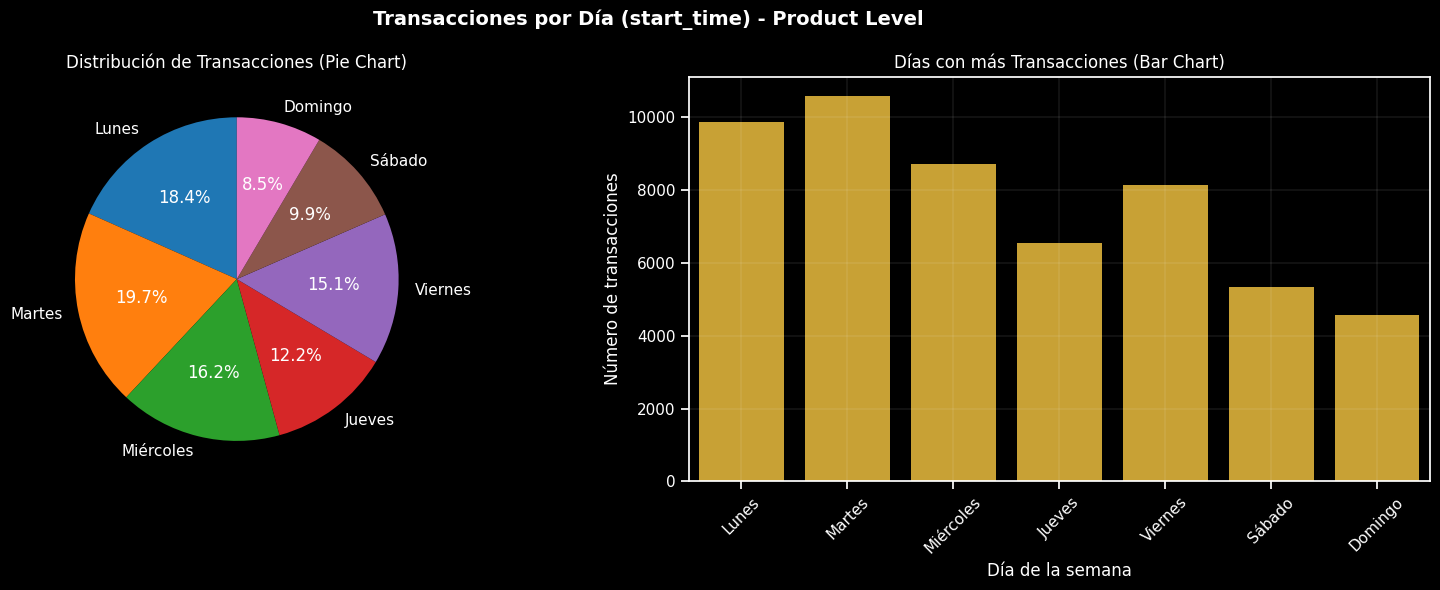

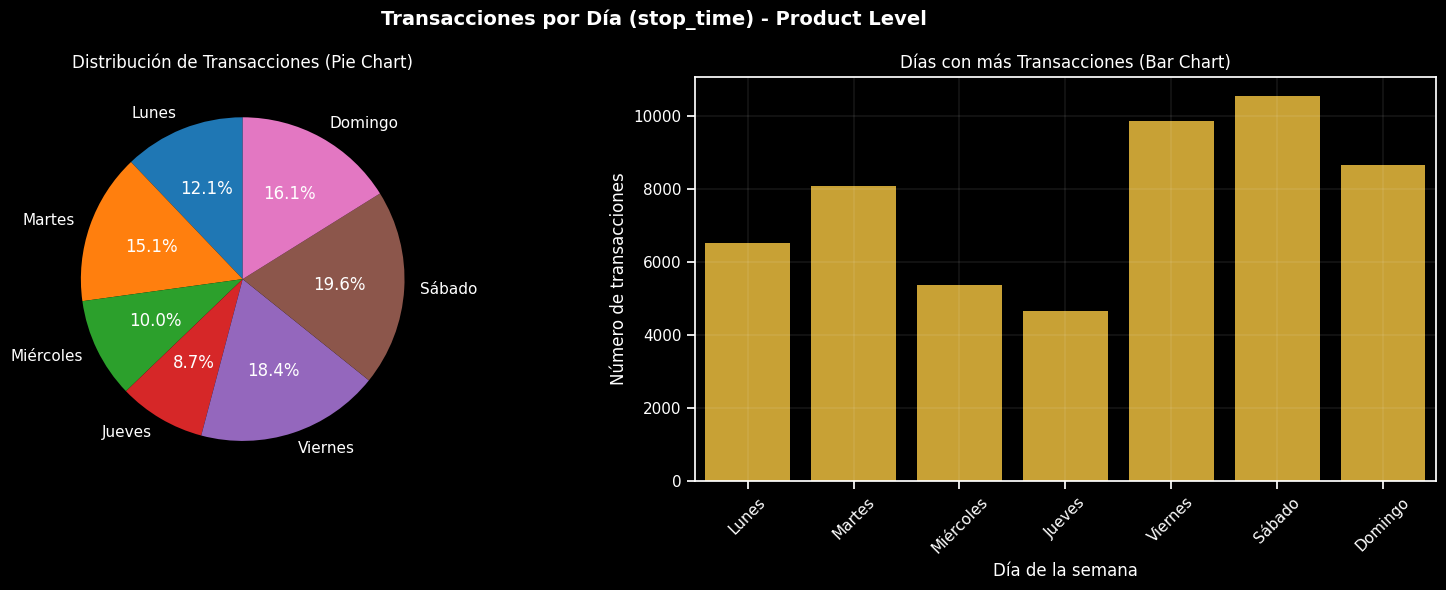

In [12]:
# Define mapping of dataframes and their corresponding colors
dataframes = {
    'Product Level': (df_product.to_pandas(), '#E0AC1C'),  
}

# List of time columns
time_cols = ['date_created', 'last_updated', 'start_time', 'stop_time']

# Day translation dictionary
day_translation = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Iterate over datasets
for title, (data, color) in dataframes.items():
    
    # Iterate over time columns
    for time_col in time_cols:
        
        # Create a figure with 2 subplots (Pie Chart + Bar Chart)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Transacciones por Día ({time_col}) - {title}', fontsize=14, fontweight='bold')

        # Filter only 'new' condition
        df_filtered = data.loc[data['condition'] == 'new'].copy()

        # Extract the day of the week
        df_filtered['day_of_week'] = df_filtered[time_col].dt.day_name().map(day_translation)

        # Count occurrences for each day
        weekday_counts = df_filtered['day_of_week'].value_counts()
        weekday_counts = weekday_counts.reindex(day_order, fill_value=0)  # Ensure all days are included

        ## 📊 Pie Chart ##
        axes[0].pie(
            weekday_counts,
            labels=weekday_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('tab10', len(weekday_counts))
        )
        axes[0].set_title('Distribución de Transacciones (Pie Chart)', fontsize=12)

        ## 📈 Bar Chart ##
        sns.barplot(
            x=weekday_counts.index,
            y=weekday_counts.values,
            order=day_order,
            color=color,
            ax=axes[1]
        )
        axes[1].set_title('Días con más Transacciones (Bar Chart)', fontsize=12)
        axes[1].set_xlabel('Día de la semana')
        axes[1].set_ylabel('Número de transacciones')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(color='white', linewidth=0.1)

        # Adjust layout and display
        plt.tight_layout()  # Prevent overlap with title
        plt.show()

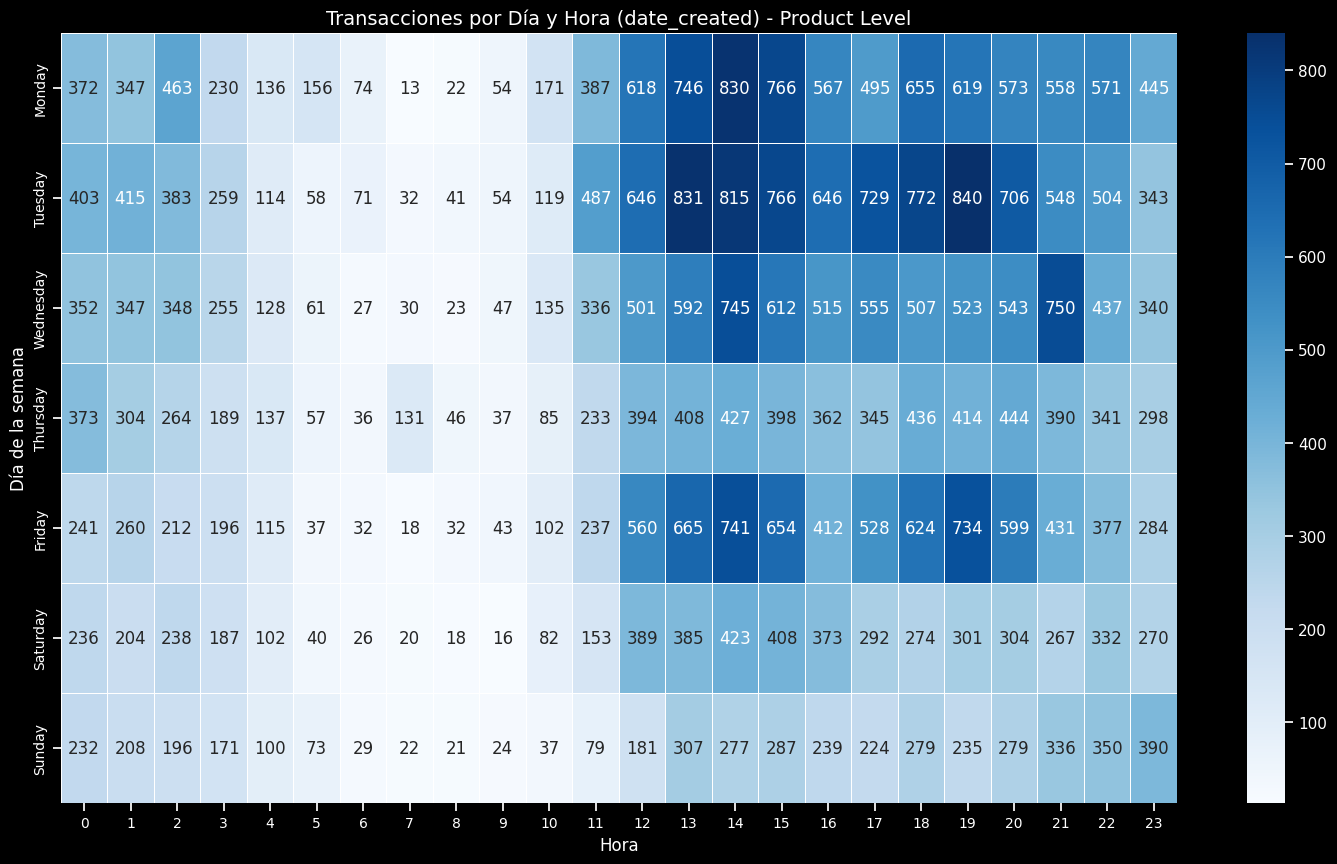

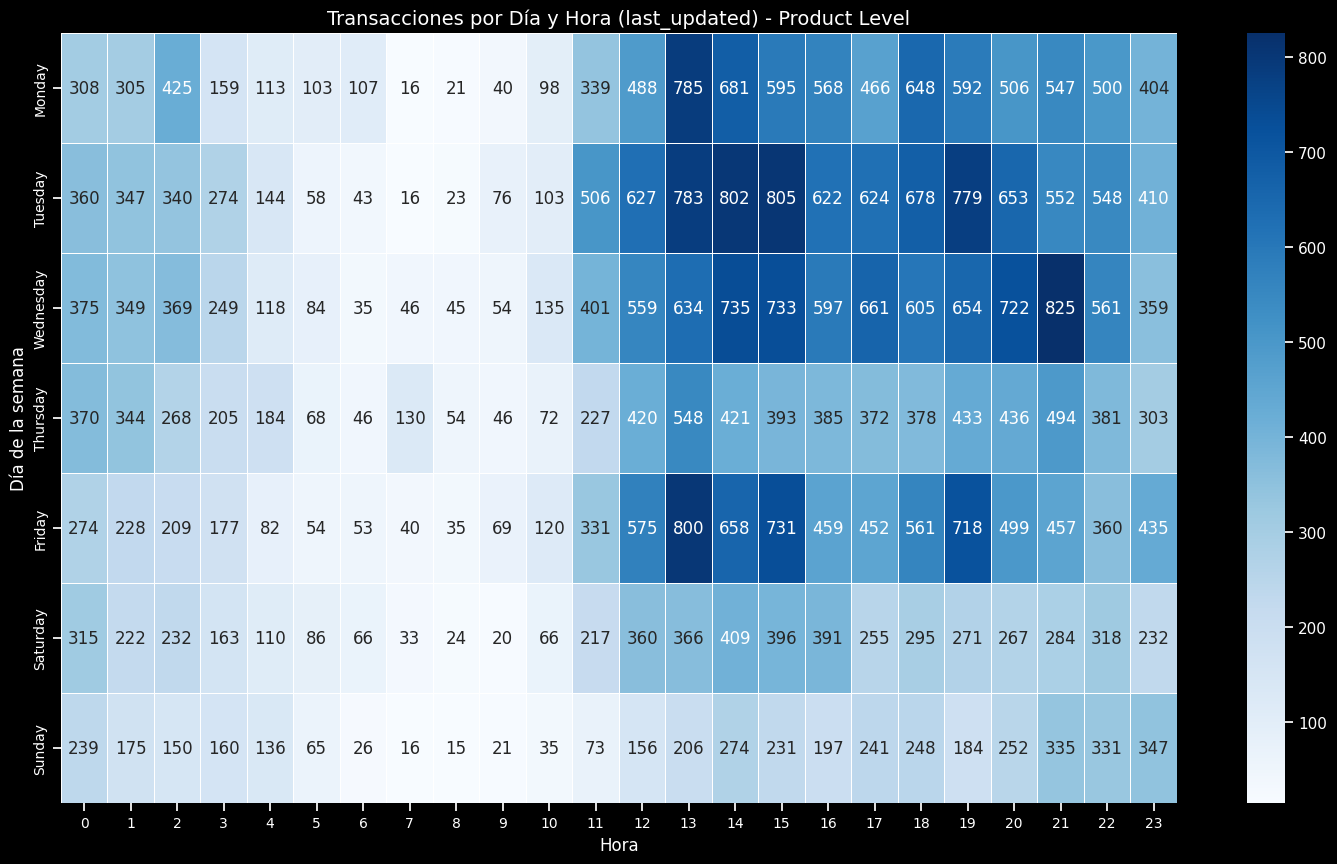

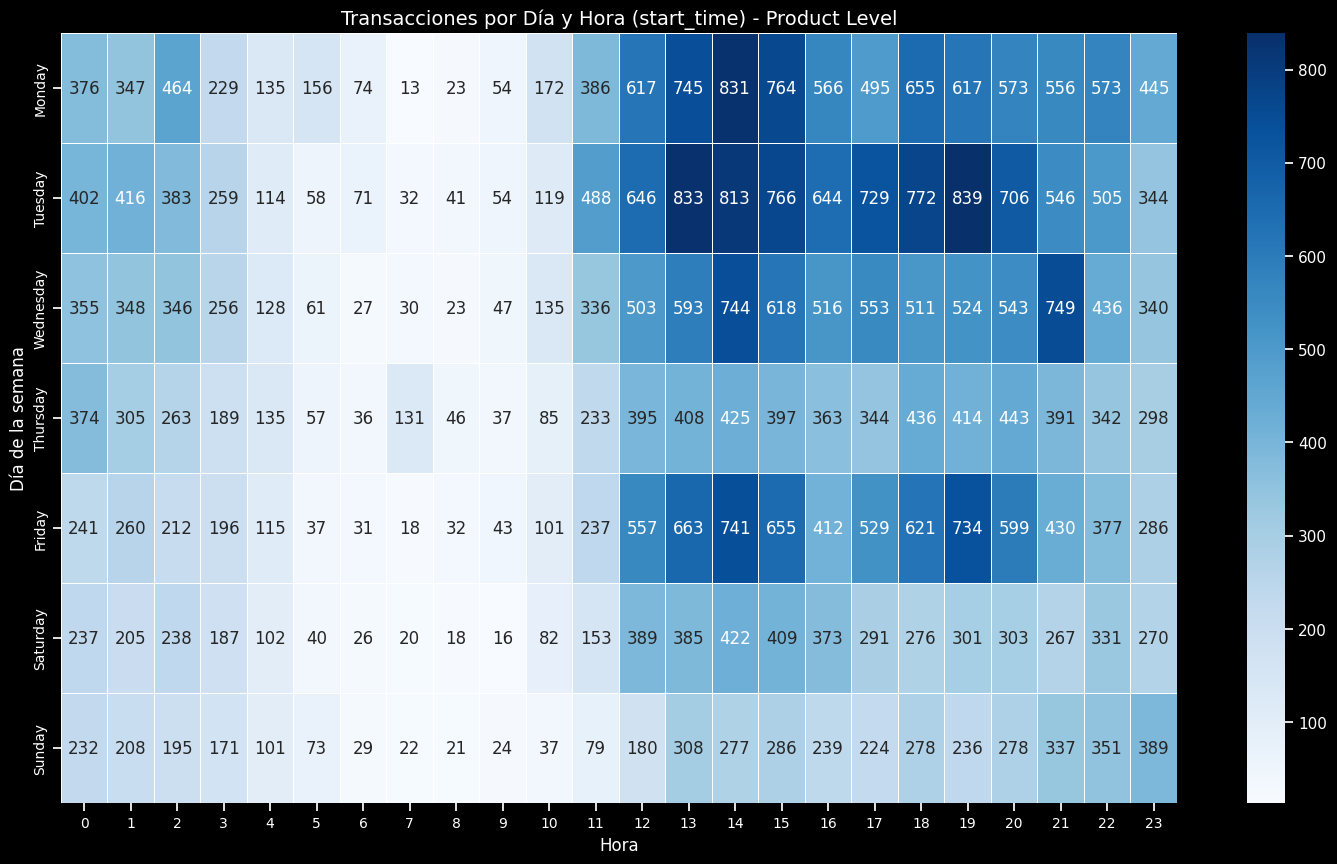

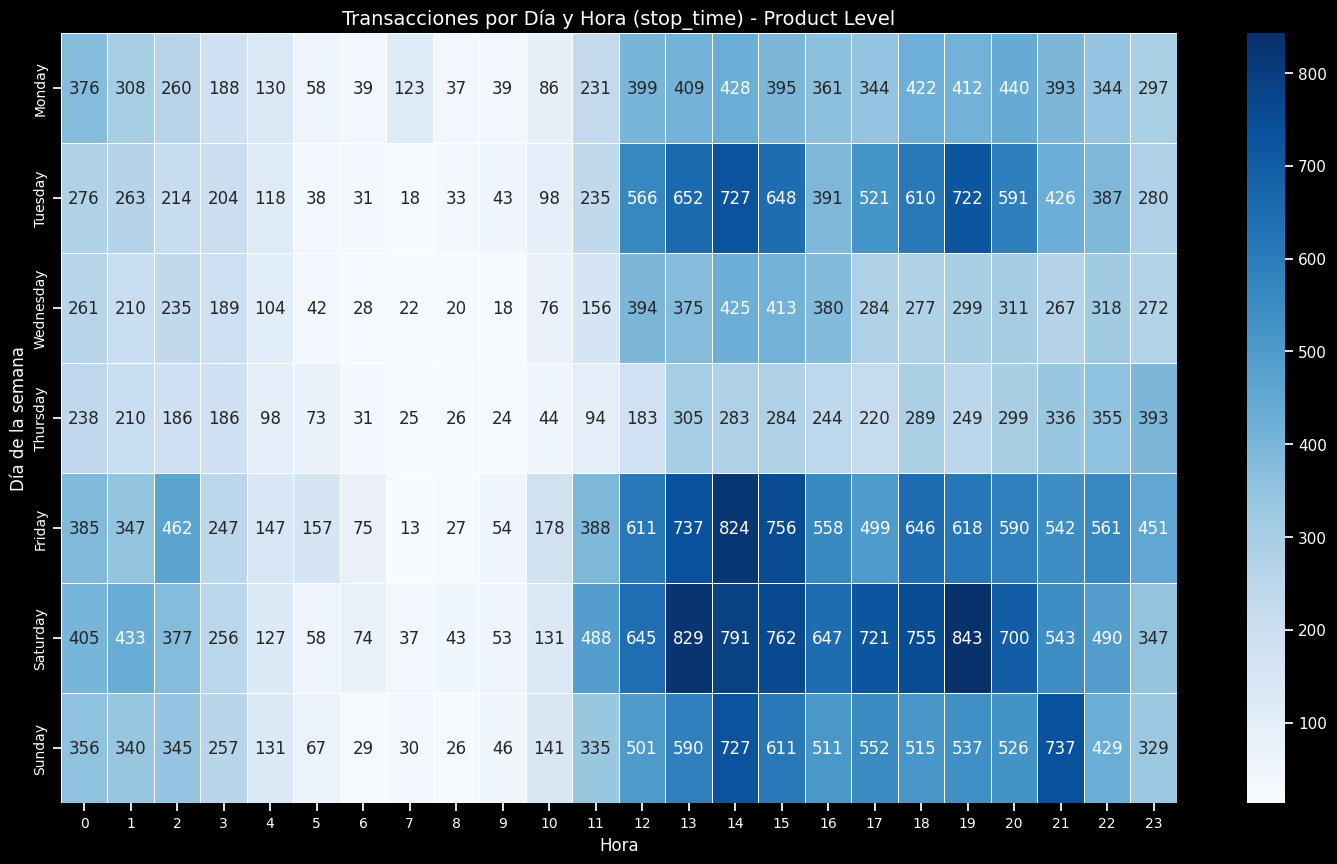

In [13]:

# Definir la lista de columnas temporales
time_cols = ['date_created', 'last_updated', 'start_time', 'stop_time']

# Diccionario de colores para cada nivel
colors = {
    "product": "Blues",  # Dorado suave
}

# Diccionario de nombres de los dataframes
dataframes = {
    "product": df_product.to_pandas(),
}

# Orden de los días de la semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterar sobre cada nivel y cada columna temporal
for level, df in dataframes.items():
    for time_col in time_cols:
        if time_col not in df.columns:
            continue  # Saltar si la columna no está en el dataframe

        # Filtrar solo productos nuevos
        df_filtered = df[df['condition'] == 'new']

        # Verificar si hay datos para evitar errores
        if df_filtered.empty:
            print(f"No hay datos para {time_col} en {level}")
            continue

        # Crear columnas adicionales para día de la semana y hora
        df_filtered = df_filtered.assign(
            day_of_week=df_filtered[time_col].dt.day_name(),
            hour=df_filtered[time_col].dt.hour
        )

        # Crear tabla cruzada (día de la semana vs hora)
        heatmap_data = pd.pivot_table( # type: ignore
            df_filtered,
            values='total_amount',  # Usa 'total_amount' para contar transacciones
            index='day_of_week',
            columns='hour',
            aggfunc='size', # type: ignore
            fill_value=0
        )

        # Reordenar los días de la semana
        heatmap_data = heatmap_data.reindex(day_order)

        # Graficar el heatmap
        plt.figure(figsize=(18, 10))
        sns.heatmap(
            heatmap_data,
            cmap=colors[level],  # Color según el nivel
            annot=True,
            fmt='d',
            linewidths=.5
        )
        plt.title(f'Transacciones por Día y Hora ({time_col}) - {level.capitalize()} Level', fontsize=14)
        plt.xlabel('Hora', fontsize=12)
        plt.ylabel('Día de la semana', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()


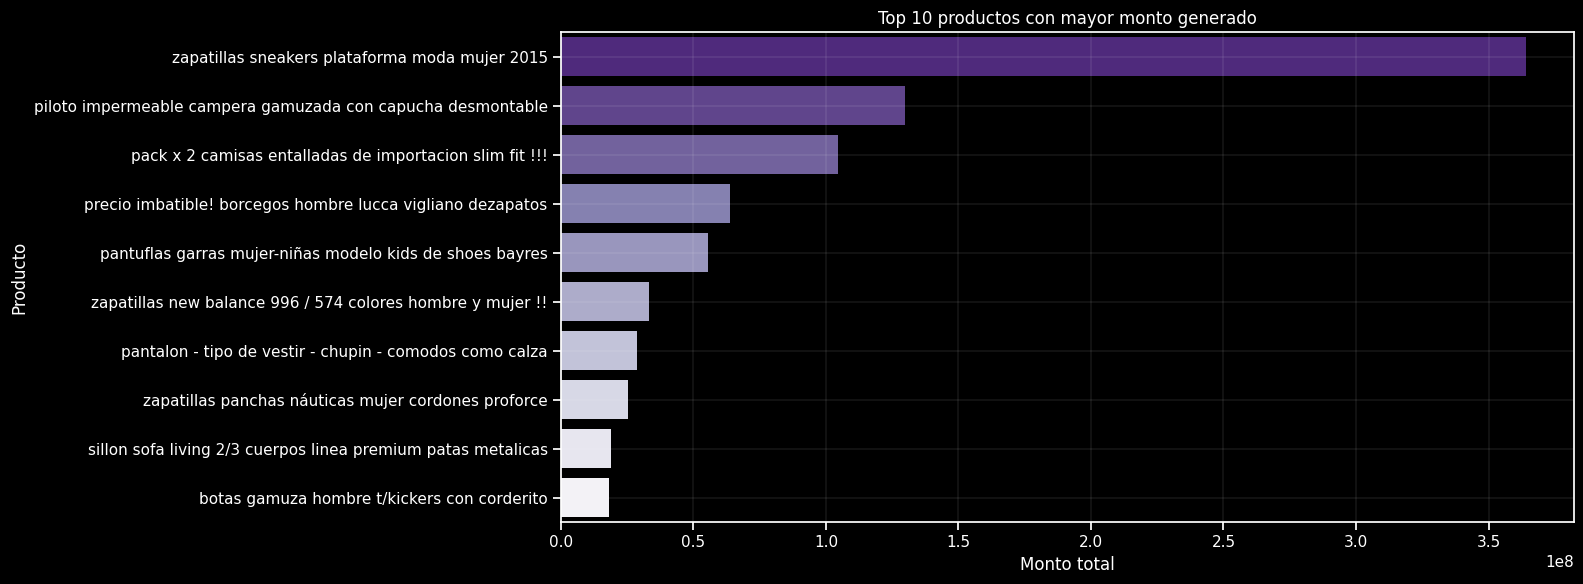

In [14]:
top_revenue_products = (
    df_product.select(['title', 'total_amount'])
    .sort('total_amount', descending=True)
    .head(10)
    .to_pandas()
)

# Creating the bar plot
plt.figure(figsize=(16, 6))
sns.barplot(
    data=top_revenue_products,
    x='total_amount',
    y='title',
    palette='Purples_r'
)
plt.title('Top 10 productos con mayor monto generado')
plt.xlabel('Monto total')
plt.ylabel('Producto')

# Adjust layout and show plot
plt.grid(color='white', linewidth=0.1)
plt.tight_layout()